<a href="https://colab.research.google.com/github/Rashed17a/Financial-Econometrics-MScFE-610-GWP/blob/main/Financial_Econometrics_GWP_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BTC-USD, ETH-USD, SOL-USD

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.gofplots import qqplot  # Import qqplot here
from scipy.stats import shapiro

In [ ]:
# Function to fetch data from Yahoo Finance
def fetch_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    data = data.dropna()  # Drop NaN values
    return data

In [ ]:
# Perform ADF test
def adf_test(series, name):
    result = adfuller(series, autolag='AIC')
    print(f"ADF Test for {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"P-value: {result[1]}")
    for key, value in result[4].items():
        print(f"Critical Values ({key}): {value}")
    print("Series is non-stationary" if result[1] > 0.05 else "Series is stationary")
    print()

In [ ]:
def kpss_test(series, name, regression_type="c", lags='auto'):
    try:
        result = kpss(series, regression=regression_type, nlags=lags)
        print(f"KPSS Test for {name}:")
        print(f"KPSS Statistic: {result[0]}")
        print(f"P-value: {result[1]}")
        for key, value in result[3].items():
            print(f"Critical Values ({key}): {value}")
        print("Series is stationary" if result[1] > 0.05 else "Series is non-stationary")
    except ValueError as e:
        print(f"Error in KPSS Test for {name}: {e}")
    print()

In [ ]:
# Function to select the optimal lag based on AIC or BIC
def select_optimal_lag(data, max_lags=15, criterion='aic'):
    model = VAR(data)
    results = model.select_order(maxlags=max_lags)

    if criterion == 'aic':
        optimal_lag = results.selected_orders['aic']
    elif criterion == 'bic':
        optimal_lag = results.selected_orders['bic']
    else:
        raise ValueError("Criterion must be either 'aic' or 'bic'")

    print(f"Optimal Lag selected based on {criterion.upper()}: {optimal_lag}")
    return optimal_lag

In [ ]:
# Enhanced Johansen Test with automatic lag selection
def johansen_test(data, det_order=0, max_lags=15, criterion='aic'):
    # Automatically select the optimal lag
    optimal_lag = select_optimal_lag(data, max_lags, criterion)

    print(f"Running Johansen Cointegration Test with det_order={det_order} and optimal lag={optimal_lag}:")
    result = coint_johansen(data, det_order, optimal_lag)

    # Eigenvalues (Strength of cointegration)
    print("Eigenvalues:", result.eig)

    # Trace Statistics (Testing the null hypothesis of at most r cointegrating vectors)
    print("Trace Statistics:", result.lr1)
    print("Critical Values (Trace) at 1%, 5%, 10%:", result.cvt)

    # Max Eigen Statistics (Testing the null hypothesis of exactly r cointegrating vectors)
    print("Max Eigen Statistics:", result.lr2)
    print("Critical Values (Max Eigen) at 1%, 5%, 10%:", result.cvm)

    # Interpret Results for Trace Test
    print("\nInterpretation (Trace Test):")
    for i, lr1 in enumerate(result.lr1):
        print(f"r={i} (at most {i} cointegrating vectors): Test Statistic = {lr1}, Critical Value = {result.cvt[i, 1]}")
        if lr1 > result.cvt[i, 1]:
            print(f"  - Reject the null hypothesis: There are more than {i} cointegrating vectors.")
        else:
            print(f"  - Fail to reject the null hypothesis: At most {i} cointegrating vectors.")

    # Interpret Results for Max Eigen Test
    print("\nInterpretation (Max Eigen Test):")
    for i, lr2 in enumerate(result.lr2):
        print(f"r={i} (exactly {i} cointegrating vectors): Test Statistic = {lr2}, Critical Value = {result.cvm[i, 1]}")
        if lr2 > result.cvm[i, 1]:
            print(f"  - Reject the null hypothesis: There is exactly {i} cointegrating vector.")
        else:
            print(f"  - Fail to reject the null hypothesis: There is more than {i} cointegrating vectors.")

    print()

In [ ]:
# Vector Error Correction Model (VECM)
def vecm_model(data, coint_rank, optimal_lag):
    print("Vector Error Correction Model (VECM):")
    model = VECM(data, k_ar_diff=optimal_lag, coint_rank=coint_rank)
    vecm = model.fit()
    print(vecm.summary())
    print()


In [ ]:
# Fetch and process data for cryptocurrency
start_date = "2015-01-01"
end_date = "2023-12-31"
tickers = ["BTC-USD", "ETH-USD", "SOL-USD"]  # Bitcoin (BTC), Ethereum (ETH), Solana (SOL)
data = fetch_data(tickers, start_date, end_date)

[*********************100%***********************]  3 of 3 completed


In [ ]:
# Apply log transformation
data_log = np.log(data).dropna()

# Add frequency information to the date index
data_log = data_log.asfreq('D')


# Check for NaN or inf values
print("Number of NaN or inf values in log-transformed data:")
print(data_log.isna().sum())
print(np.isinf(data_log).sum())

# Drop rows with NaN or inf values
data_log = data_log.replace([np.inf, -np.inf], np.nan).dropna()

Number of NaN or inf values in log-transformed data:
Ticker
BTC-USD    0
ETH-USD    0
SOL-USD    0
dtype: int64
Ticker
BTC-USD    0
ETH-USD    0
SOL-USD    0
dtype: int64


In [ ]:
# Perform stationarity tests
print("Stationarity Tests on Log-Transformed Levels:")
adf_test(data["BTC-USD"], "Bitcoin (Log Levels)")
adf_test(data["ETH-USD"], "Ethereum (Log Levels)")
adf_test(data["SOL-USD"], "Solana (Log Levels)")

kpss_test(data_log["BTC-USD"], "Bitcoin (Log Levels)")
kpss_test(data_log["ETH-USD"], "Ethereum (Log Levels)")
kpss_test(data_log["SOL-USD"], "Solana (Log Levels)")

Stationarity Tests on Log-Transformed Levels:
ADF Test for Bitcoin (Log Levels):
ADF Statistic: -1.9240037884077952
P-value: 0.32085458111579657
Critical Values (1%): -3.4352031686360815
Critical Values (5%): -2.863683302419347
Critical Values (10%): -2.567911096844993
Series is non-stationary

ADF Test for Ethereum (Log Levels):
ADF Statistic: -1.9996300433841812
P-value: 0.2867353358088911
Critical Values (1%): -3.435192387210374
Critical Values (5%): -2.8636785448741353
Critical Values (10%): -2.5679085632868626
Series is non-stationary

ADF Test for Solana (Log Levels):
ADF Statistic: -1.9179265029014076
P-value: 0.3236754777717837
Critical Values (1%): -3.4352578040092436
Critical Values (5%): -2.863707411237363
Critical Values (10%): -2.5679239356703
Series is non-stationary

KPSS Test for Bitcoin (Log Levels):
KPSS Statistic: 1.1611856198398813
P-value: 0.01
Critical Values (10%): 0.347
Critical Values (5%): 0.463
Critical Values (2.5%): 0.574
Critical Values (1%): 0.739
Series 

C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4272121313.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)
C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4272121313.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)
C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4272121313.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)


In [ ]:
# Differencing to make the series stationary
data_diff = data.diff().dropna()

# Perform stationarity tests on First Difference levels
print("Stationarity Tests on Raw Data Levels:")
adf_test(data_diff["BTC-USD"], "Bitcoin (Raw Levels)")
adf_test(data_diff["ETH-USD"], "Ethereum (Raw Levels)")
adf_test(data_diff["SOL-USD"], "Solana (Raw Levels)")

kpss_test(data_diff["BTC-USD"], "Bitcoin (Raw Levels)")
kpss_test(data_diff["ETH-USD"], "Ethereum (Raw Levels)")
kpss_test(data_diff["SOL-USD"], "Solana (Raw Levels)")

Stationarity Tests on Raw Data Levels:
ADF Test for Bitcoin (Raw Levels):
ADF Statistic: -11.563270851220022
P-value: 3.2315157406104357e-21
Critical Values (1%): -3.4352031686360815
Critical Values (5%): -2.863683302419347
Critical Values (10%): -2.567911096844993
Series is stationary

ADF Test for Ethereum (Raw Levels):
ADF Statistic: -9.283942444164955
P-value: 1.2298035268542928e-15
Critical Values (1%): -3.4352321552179914
Critical Values (5%): -2.863696093312285
Critical Values (10%): -2.567917908453473
Series is stationary

ADF Test for Solana (Raw Levels):
ADF Statistic: -5.871467962928933
P-value: 3.2327215572659327e-07
Critical Values (1%): -3.4352578040092436
Critical Values (5%): -2.863707411237363
Critical Values (10%): -2.5679239356703
Series is stationary

KPSS Test for Bitcoin (Raw Levels):
KPSS Statistic: 0.16221369614562137
P-value: 0.1
Critical Values (10%): 0.347
Critical Values (5%): 0.463
Critical Values (2.5%): 0.574
Critical Values (1%): 0.739
Series is stationa

C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4272121313.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)
C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4272121313.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)
C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4272121313.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)


In [ ]:
# Differencing to make the series stationary
data_log_diff = data_log.diff().dropna()

# Perform stationarity tests on log-transformed levels
print("Stationarity Tests on Raw Data Levels:")
adf_test(data_log["BTC-USD"], "Bitcoin (Raw Levels)")
adf_test(data_log["ETH-USD"], "Ethereum (Raw Levels)")
adf_test(data_log["SOL-USD"], "Solana (Raw Levels)")

kpss_test(data_log["BTC-USD"], "Bitcoin (Raw Levels)")
kpss_test(data_log["ETH-USD"], "Ethereum (Raw Levels)")
kpss_test(data_log["SOL-USD"], "Solana (Raw Levels)")

Stationarity Tests on Raw Data Levels:
ADF Test for Bitcoin (Raw Levels):
ADF Statistic: -2.3546969345565425
P-value: 0.15493305516542405
Critical Values (1%): -3.435170967430817
Critical Values (5%): -2.8636690928667523
Critical Values (10%): -2.5679035297726274
Series is non-stationary

ADF Test for Ethereum (Raw Levels):
ADF Statistic: -2.6771692794661606
P-value: 0.07807298657975677
Critical Values (1%): -3.4352067731212785
Critical Values (5%): -2.863684892975246
Critical Values (10%): -2.5679119438718847
Series is non-stationary

ADF Test for Solana (Raw Levels):
ADF Statistic: -1.7669158793485107
P-value: 0.3970062830998094
Critical Values (1%): -3.4351745242248715
Critical Values (5%): -2.8636706623947417
Critical Values (10%): -2.567904365598721
Series is non-stationary

KPSS Test for Bitcoin (Raw Levels):
KPSS Statistic: 1.1611856198398813
P-value: 0.01
Critical Values (10%): 0.347
Critical Values (5%): 0.463
Critical Values (2.5%): 0.574
Critical Values (1%): 0.739
Series is

C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4272121313.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)
C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4272121313.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)
C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4272121313.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)


In [ ]:
# Perform stationarity tests on first differences
print("Stationarity Tests on First Differences:")
adf_test(data_log_diff["BTC-USD"], "Bitcoin (First Differences)")
adf_test(data_log_diff["ETH-USD"], "Ethereum (First Differences)")
adf_test(data_log_diff["SOL-USD"], "Solana (First Differences)")

kpss_test(data_log_diff["BTC-USD"], "Bitcoin (First Differences)")
kpss_test(data_log_diff["ETH-USD"], "Ethereum (First Differences)")
kpss_test(data_log_diff["SOL-USD"], "Solana (First Differences)")

Stationarity Tests on First Differences:
ADF Test for Bitcoin (First Differences):
ADF Statistic: -37.65076956010419
P-value: 0.0
Critical Values (1%): -3.4351745242248715
Critical Values (5%): -2.8636706623947417
Critical Values (10%): -2.567904365598721
Series is stationary

ADF Test for Ethereum (First Differences):
ADF Statistic: -10.880142263074296
P-value: 1.3010726651500434e-19
Critical Values (1%): -3.4352067731212785
Critical Values (5%): -2.863684892975246
Critical Values (10%): -2.5679119438718847
Series is stationary

ADF Test for Solana (First Differences):
ADF Statistic: -38.76511247552104
P-value: 0.0
Critical Values (1%): -3.4351745242248715
Critical Values (5%): -2.8636706623947417
Critical Values (10%): -2.567904365598721
Series is stationary

KPSS Test for Bitcoin (First Differences):
KPSS Statistic: 0.39623032544792697
P-value: 0.07878003213451423
Critical Values (10%): 0.347
Critical Values (5%): 0.463
Critical Values (2.5%): 0.574
Critical Values (1%): 0.739
Serie

C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4272121313.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)


In [ ]:
# Run Johansen cointegration test on log-transformed levels
print("Johansen Cointegration Test on Log-Transformed Levels:")
johansen_test(data_log, det_order=0, max_lags=15, criterion='aic')


Johansen Cointegration Test on Log-Transformed Levels:
Optimal Lag selected based on AIC: 2
Running Johansen Cointegration Test with det_order=0 and optimal lag=2:
Eigenvalues: [0.01574374 0.00988191 0.00574779]
Trace Statistics: [42.832922   21.2987063   7.82225268]
Critical Values (Trace) at 1%, 5%, 10%: [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max Eigen Statistics: [21.53421571 13.47645362  7.82225268]
Critical Values (Max Eigen) at 1%, 5%, 10%: [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]

Interpretation (Trace Test):
r=0 (at most 0 cointegrating vectors): Test Statistic = 42.83292200449962, Critical Value = 29.7961
  - Reject the null hypothesis: There are more than 0 cointegrating vectors.
r=1 (at most 1 cointegrating vectors): Test Statistic = 21.298706297988602, Critical Value = 15.4943
  - Reject the null hypothesis: There are more than 1 cointegrating vectors.
r=2 (at most 2 cointegrating vectors): 

In [ ]:
# Fit VECM on log-transformed levels if cointegration rank > 0
coint_rank = 1 # Example rank based on Johansen test result
optimal_lag = select_optimal_lag(data_log, max_lags=15, criterion='aic')
if coint_rank > 0:
    vecm_model(data_log, coint_rank, optimal_lag)


Optimal Lag selected based on AIC: 2
Vector Error Correction Model (VECM):
Det. terms outside the coint. relation & lagged endog. parameters for equation BTC-USD
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.BTC-USD     0.0722      0.046      1.564      0.118      -0.018       0.163
L1.ETH-USD    -0.0803      0.038     -2.124      0.034      -0.154      -0.006
L1.SOL-USD    -0.0119      0.015     -0.778      0.437      -0.042       0.018
L2.BTC-USD    -0.0244      0.046     -0.530      0.596      -0.115       0.066
L2.ETH-USD     0.0389      0.038      1.030      0.303      -0.035       0.113
L2.SOL-USD     0.0008      0.015      0.051      0.959      -0.029       0.031
Det. terms outside the coint. relation & lagged endog. parameters for equation ETH-USD
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

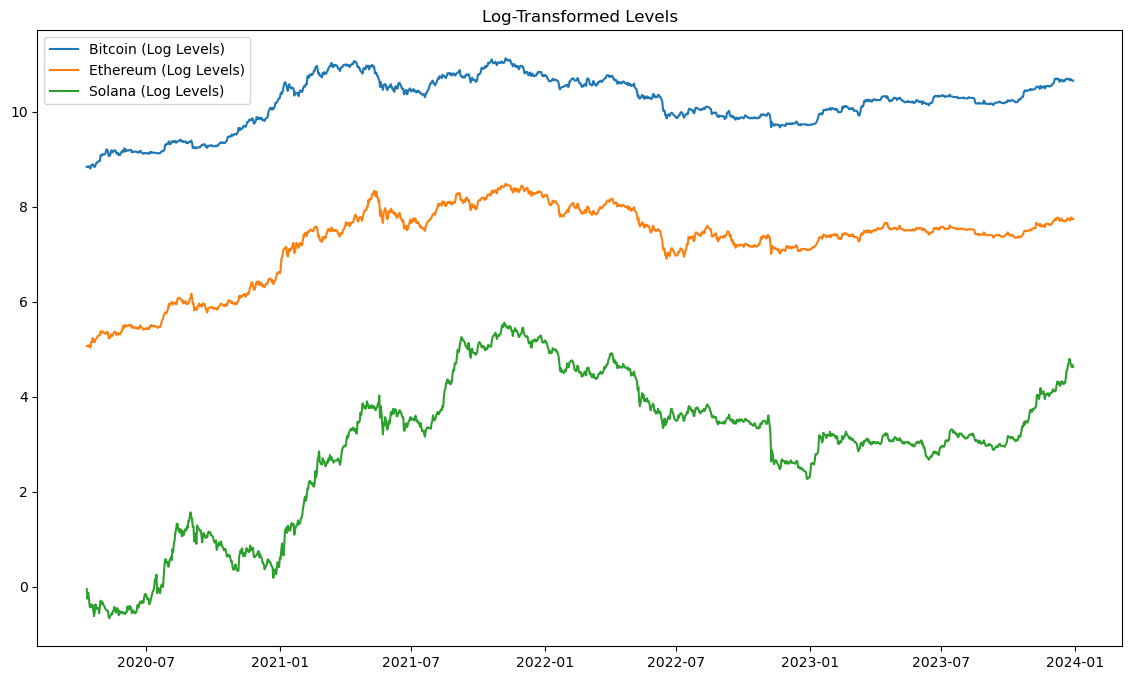

In [ ]:
# Plot log-transformed levels
plt.figure(figsize=(14, 8))
plt.plot(data_log["BTC-USD"], label="Bitcoin (Log Levels)")
plt.plot(data_log["ETH-USD"], label="Ethereum (Log Levels)")
plt.plot(data_log["SOL-USD"], label="Solana (Log Levels)")
plt.title("Log-Transformed Levels")
plt.legend()
plt.show()

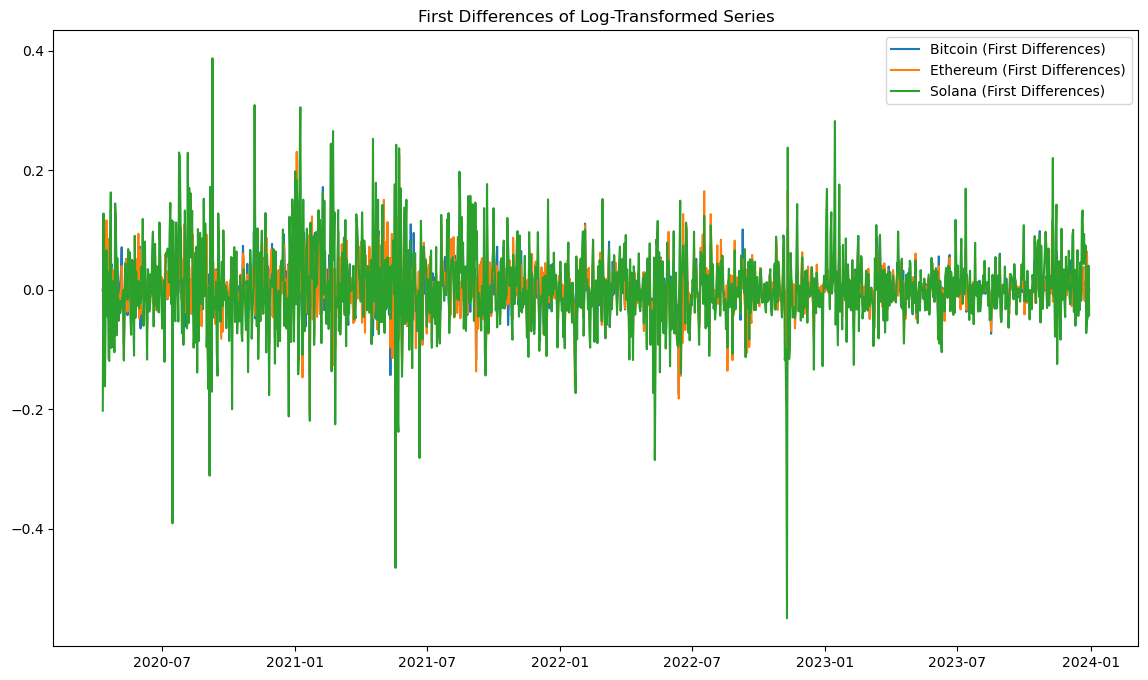

In [ ]:
# Plot first differences
plt.figure(figsize=(14, 8))
plt.plot(data_log_diff["BTC-USD"], label="Bitcoin (First Differences)")
plt.plot(data_log_diff["ETH-USD"], label="Ethereum (First Differences)")
plt.plot(data_log_diff["SOL-USD"], label="Solana (First Differences)")
plt.title("First Differences of Log-Transformed Series")
plt.legend()
plt.show()

In [ ]:
# Fit VECM and plot residuals
vecm = VECM(data_log, k_ar_diff=optimal_lag, coint_rank=coint_rank).fit()
residuals = vecm.resid  # This is a NumPy array

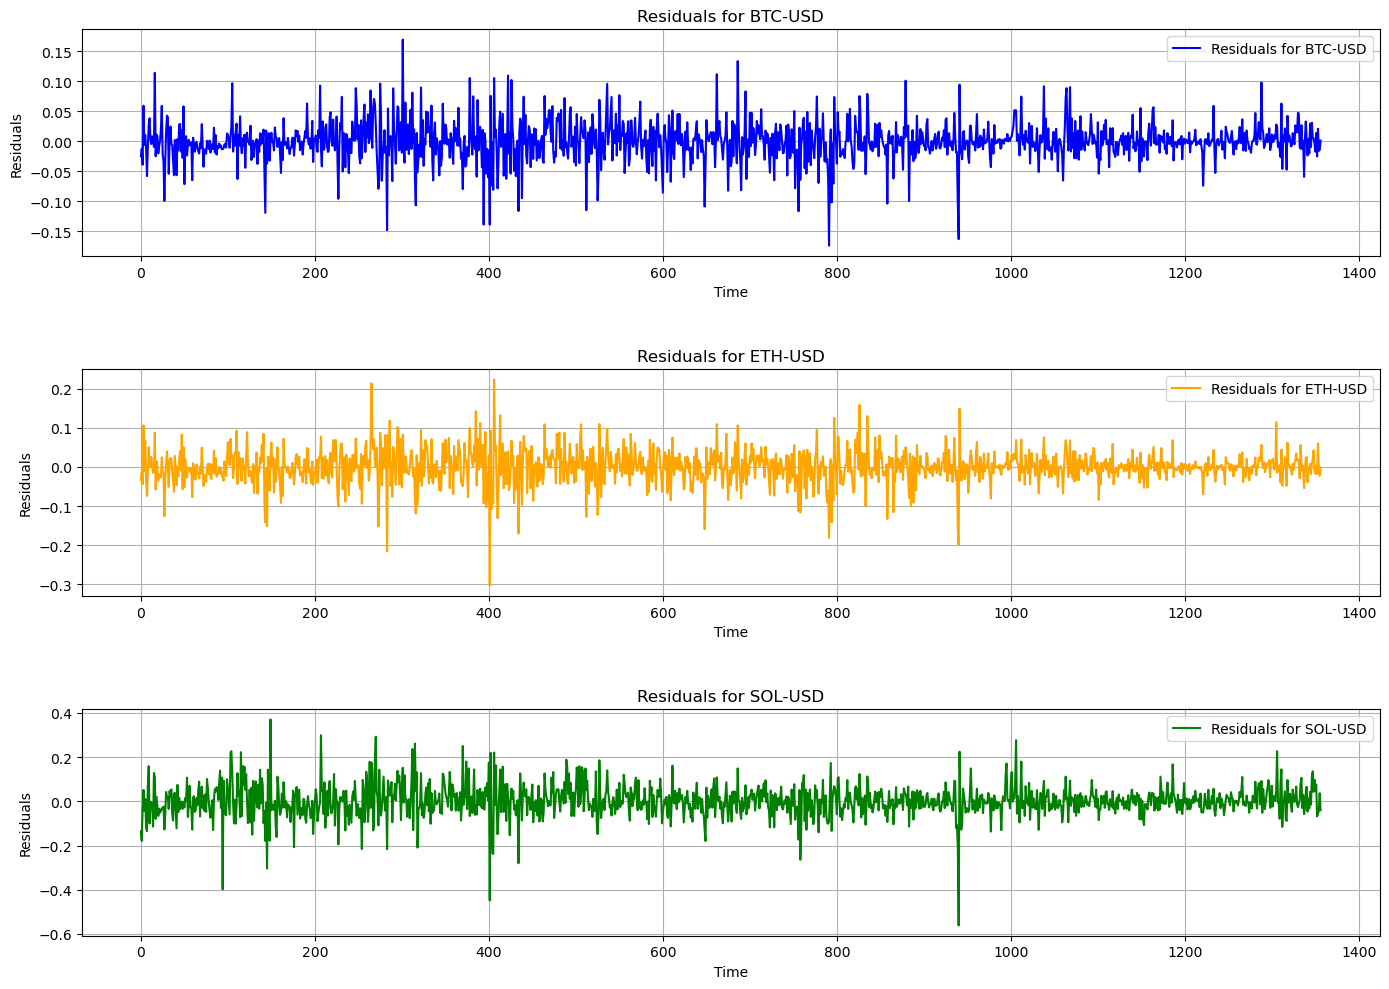

In [ ]:
# Plot residuals for each variable in separate subplots
plt.figure(figsize=(14, 10))
colors = ["blue", "orange", "green"]  # Custom colors
for i, column in enumerate(data_log.columns):
    plt.subplot(len(data_log.columns), 1, i + 1)  # Create subplots
    plt.plot(residuals[:, i], label=f"Residuals for {column}", color=colors[i])
    plt.title(f"Residuals for {column}")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to avoid overlap
plt.subplots_adjust(hspace=0.5)  # Adjust subplot spacing
plt.show()

In [ ]:
# Check for NaN or inf values in residuals
print("Number of NaN or inf values in residuals:")
for i, column in enumerate(data_log.columns):
    print(f"{column}: NaN={np.isnan(residuals[:, i]).sum()}, inf={np.isinf(residuals[:, i]).sum()}")

Number of NaN or inf values in residuals:
BTC-USD: NaN=0, inf=0
ETH-USD: NaN=0, inf=0
SOL-USD: NaN=0, inf=0


In [ ]:
# Check the shape of residuals
print("Shape of residuals:", residuals.shape)

Shape of residuals: (1357, 3)


In [ ]:
# Check residuals for the first variable (CL=F)
print("Residuals for CL=F (first 10 values):")
print(residuals[:10, 0])

Residuals for CL=F (first 10 values):
[-0.02521882 -0.01254458 -0.03919203  0.0593133  -0.00617441  0.01027163
 -0.01217993 -0.05804817 -0.01045184  0.02751546]


<Figure size 1400x800 with 0 Axes>

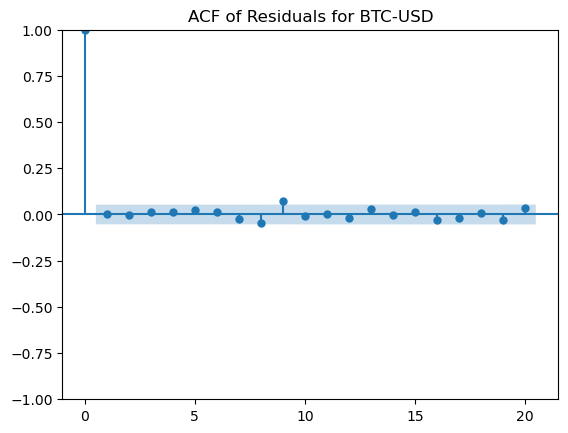

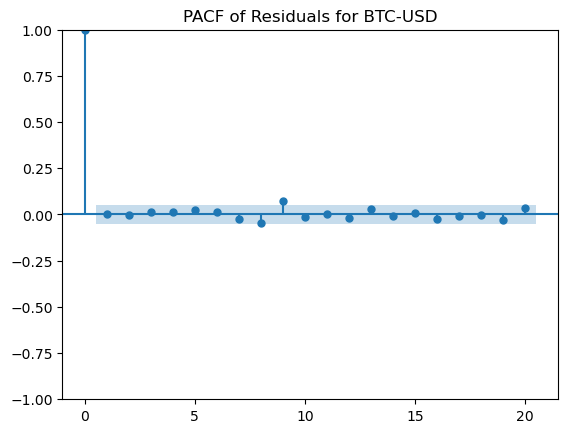

In [ ]:
# Simplified plotting for the first variable (CL=F)
plt.figure(figsize=(14, 8))

# ACF plot
plot_acf(residuals[:, 0], lags=20, title=f"ACF of Residuals for {data_log.columns[0]}")
plt.show()

# PACF plot
plot_pacf(residuals[:, 0], lags=20, title=f"PACF of Residuals for {data_log.columns[0]}")
plt.show()

In [ ]:
# Check for NaN or infinite values in residuals
print("Checking for NaN or infinite values in residuals:")
for i, column in enumerate(data_log.columns):
    print(f"{column}: NaN={np.isnan(residuals[:, i]).sum()}, inf={np.isinf(residuals[:, i]).sum()}")

# Clean residuals by replacing NaN and infinite values with 0 (or handle appropriately)
residuals_clean = np.nan_to_num(residuals)

Checking for NaN or infinite values in residuals:
BTC-USD: NaN=0, inf=0
ETH-USD: NaN=0, inf=0
SOL-USD: NaN=0, inf=0


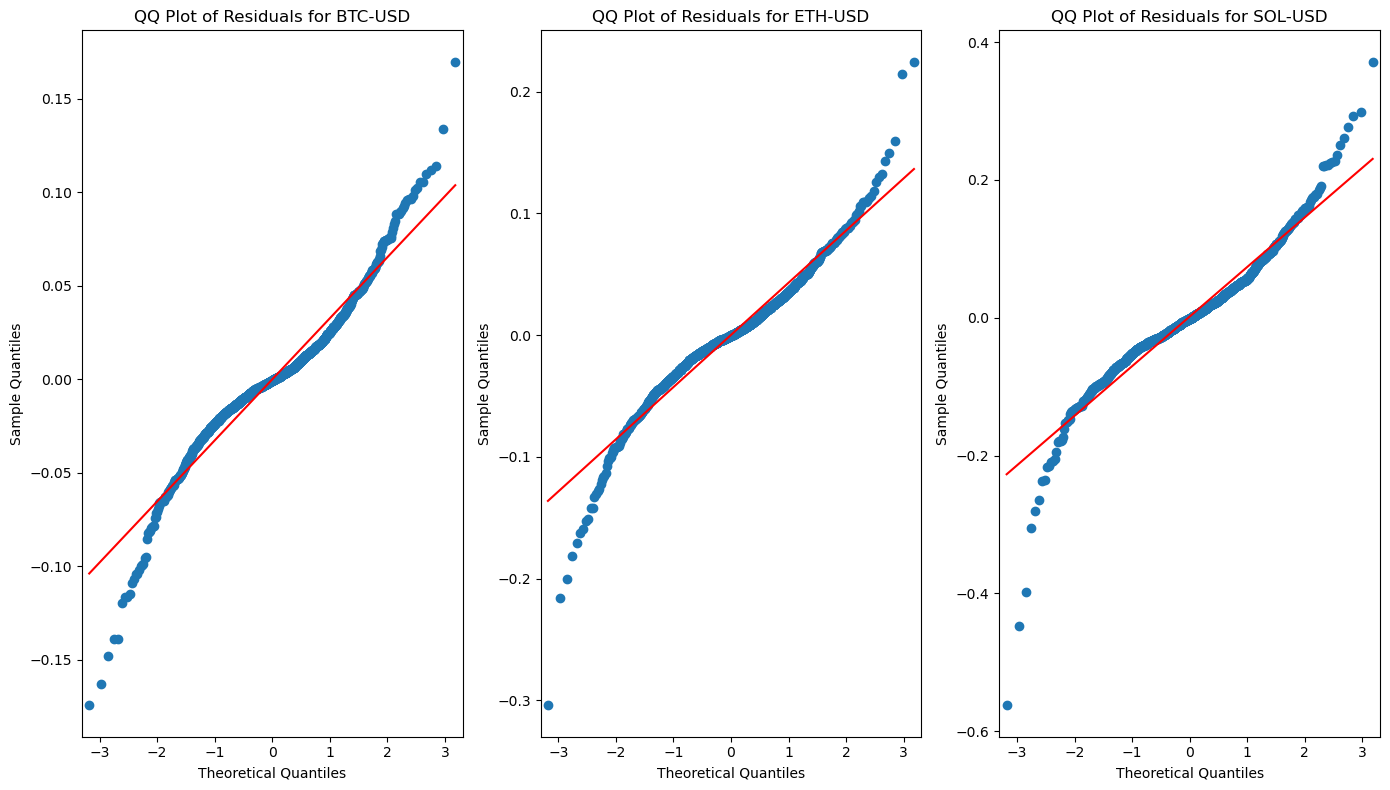

In [ ]:
# QQ plot and Shapiro-Wilk test
plt.figure(figsize=(14, 8))
for i, column in enumerate(data_log.columns):
    plt.subplot(1, len(data_log.columns), i + 1)
    qqplot(residuals_clean[:, i], line='s', ax=plt.gca())  # Use ax=plt.gca() to specify the current subplot
    plt.title(f"QQ Plot of Residuals for {column}", fontsize=12)  # Corrected title
    plt.xlabel("Theoretical Quantiles", fontsize=10)  # Explicitly set x-axis label
    plt.ylabel("Sample Quantiles", fontsize=10)  # Explicitly set y-axis label
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
# Shapiro-Wilk Test for Normality on Residuals
for i, column in enumerate(data_log.columns):
    stat, p_value = shapiro(residuals_clean[:, i])  # Perform the Shapiro-Wilk test
    print(f"Shapiro-Wilk Test for {column}:")
    print(f"Test Statistic: {stat}, P-value: {p_value}")
    if p_value > 0.05:
        print(f"The residuals for {column} are normally distributed.")
    else:
        print(f"The residuals for {column} are not normally distributed.")
    print()


Shapiro-Wilk Test for BTC-USD:
Test Statistic: 0.9426994323730469, P-value: 1.6608346808031714e-22
The residuals for BTC-USD are not normally distributed.

Shapiro-Wilk Test for ETH-USD:
Test Statistic: 0.9482219815254211, P-value: 1.9352157002555175e-21
The residuals for ETH-USD are not normally distributed.

Shapiro-Wilk Test for SOL-USD:
Test Statistic: 0.9370518922805786, P-value: 1.608441158496597e-23
The residuals for SOL-USD are not normally distributed.



In [ ]:
for i, column in enumerate(data_log.columns):
    lb_test = acorr_ljungbox(residuals_clean[:, i], lags=20)
    print(f"Ljung-Box Test for {column}:")
    print(lb_test)

Ljung-Box Test for BTC-USD:
      lb_stat  lb_pvalue
1    0.000273   0.986815
2    0.026015   0.987077
3    0.224741   0.973500
4    0.540880   0.969401
5    1.216668   0.943268
6    1.414257   0.964985
7    2.259053   0.944123
8    5.233352   0.732369
9   12.739637   0.174746
10  12.893849   0.229668
11  12.896935   0.300115
12  13.450906   0.337136
13  14.583115   0.334095
14  14.619657   0.404638
15  14.840065   0.462998
16  15.870236   0.462054
17  16.287729   0.503537
18  16.344216   0.568538
19  17.788609   0.536598
20  19.341083   0.499765
Ljung-Box Test for ETH-USD:
      lb_stat  lb_pvalue
1    0.004400   0.947112
2    0.038534   0.980918
3    0.358982   0.948579
4    0.359157   0.985682
5    3.158478   0.675568
6    7.844428   0.249724
7    8.022764   0.330591
8   14.975403   0.059625
9   15.474070   0.078710
10  22.019345   0.015006
11  24.336374   0.011387
12  24.995526   0.014844
13  27.589253   0.010321
14  30.237010   0.007078
15  31.087767   0.008550
16  32.113602   0.0

In [ ]:
for i, column in enumerate(data_log.columns):
    arch_test = het_arch(residuals_clean[:, i])
    print(f"ARCH Test for {column}:")
    print(arch_test)

ARCH Test for BTC-USD:
(34.03112036348851, 0.00018246965270391283, 3.462806888325297, 0.0001649915968759727)
ARCH Test for ETH-USD:
(99.73794596118933, 6.1491289790808e-17, 10.683392104543456, 1.314066244155933e-17)
ARCH Test for SOL-USD:
(89.4524109328382, 6.876805997184648e-15, 9.503292125502952, 2.0715727765526366e-15)


In [ ]:
from scipy.stats import jarque_bera

for i, column in enumerate(data_log.columns):
    jb_test = jarque_bera(residuals_clean[:, i])
    print(f"Jarque-Bera Test for {column}:")
    print(f"Test Statistic: {jb_test[0]}, P-value: {jb_test[1]}")

Jarque-Bera Test for BTC-USD:
Test Statistic: 755.818008874519, P-value: 7.519772664784208e-165
Jarque-Bera Test for ETH-USD:
Test Statistic: 1246.780017485695, P-value: 1.8414466002868325e-271
Jarque-Bera Test for SOL-USD:
Test Statistic: 2196.2909902608476, P-value: 0.0


In [ ]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid

for i, column in enumerate(data_log.columns):
    cusum_test = breaks_cusumolsresid(residuals_clean[:, i])
    print(f"CUSUM Test for {column}:")
    print(f"Test Statistic: {cusum_test[0]}, P-value: {cusum_test[1]}")

CUSUM Test for BTC-USD:
Test Statistic: 0.7521681091832065, P-value: 0.6235182422288073
CUSUM Test for ETH-USD:
Test Statistic: 0.7177472667379329, P-value: 0.6815244062458096
CUSUM Test for SOL-USD:
Test Statistic: 1.1937647495218697, P-value: 0.11564907931510165


<Figure size 1200x800 with 0 Axes>

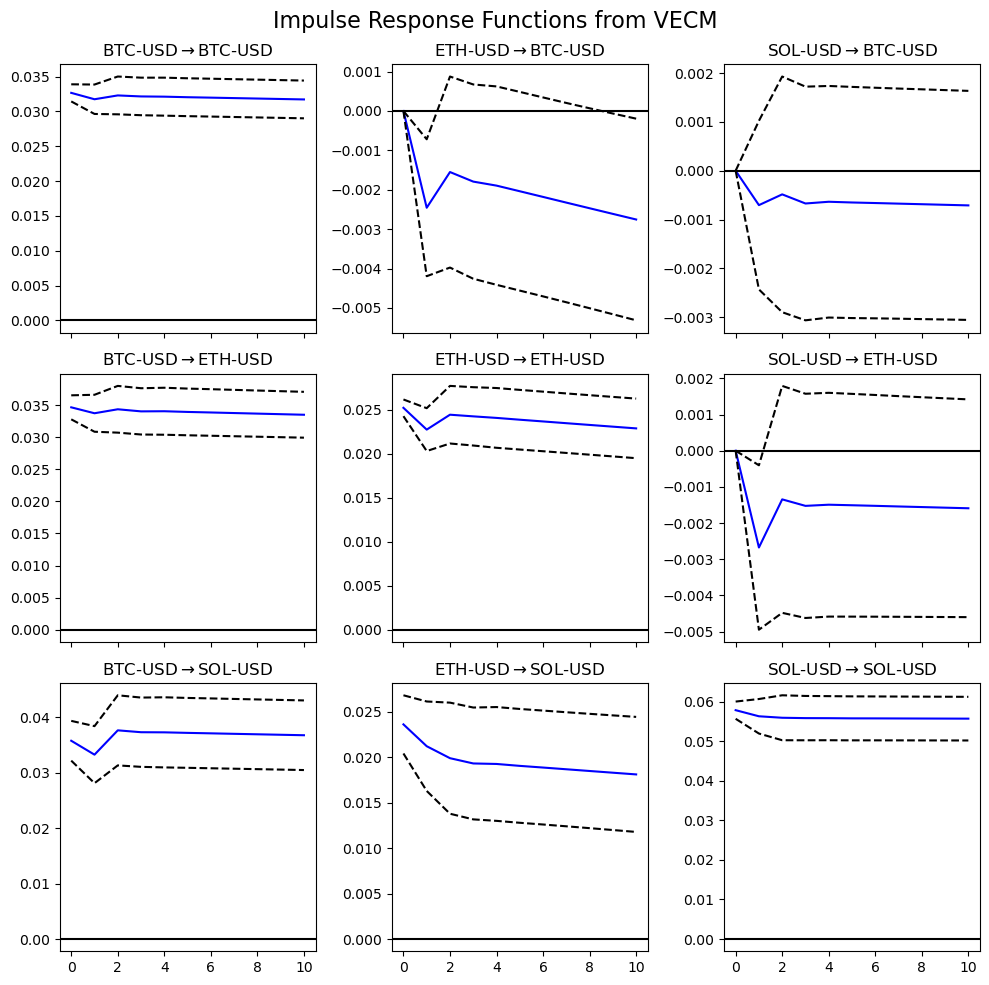

Error: Cumulative responses could not be plotted. Check if 'orth_lr_effects' are available.


In [ ]:
# Generate impulse response functions from the VECM model
irf = vecm.irf(10)  # Compute IRFs for 10 periods ahead

# Plot the impulse response functions
plt.figure(figsize=(12, 8))
irf.plot(orth=True)  # You can set orth=False for non-orthogonalized IRFs
plt.suptitle("Impulse Response Functions from VECM", fontsize=16)
plt.tight_layout()
plt.show()

# For cumulative responses (if orthogonalized responses are available):
try:
    irf.plot_cum_effects(orth=True)  # This is where the error occurred earlier
    plt.suptitle("Cumulative Impulse Response Functions from VECM", fontsize=16)
    plt.tight_layout()
    plt.show()
except AttributeError:
    print("Error: Cumulative responses could not be plotted. Check if 'orth_lr_effects' are available.")


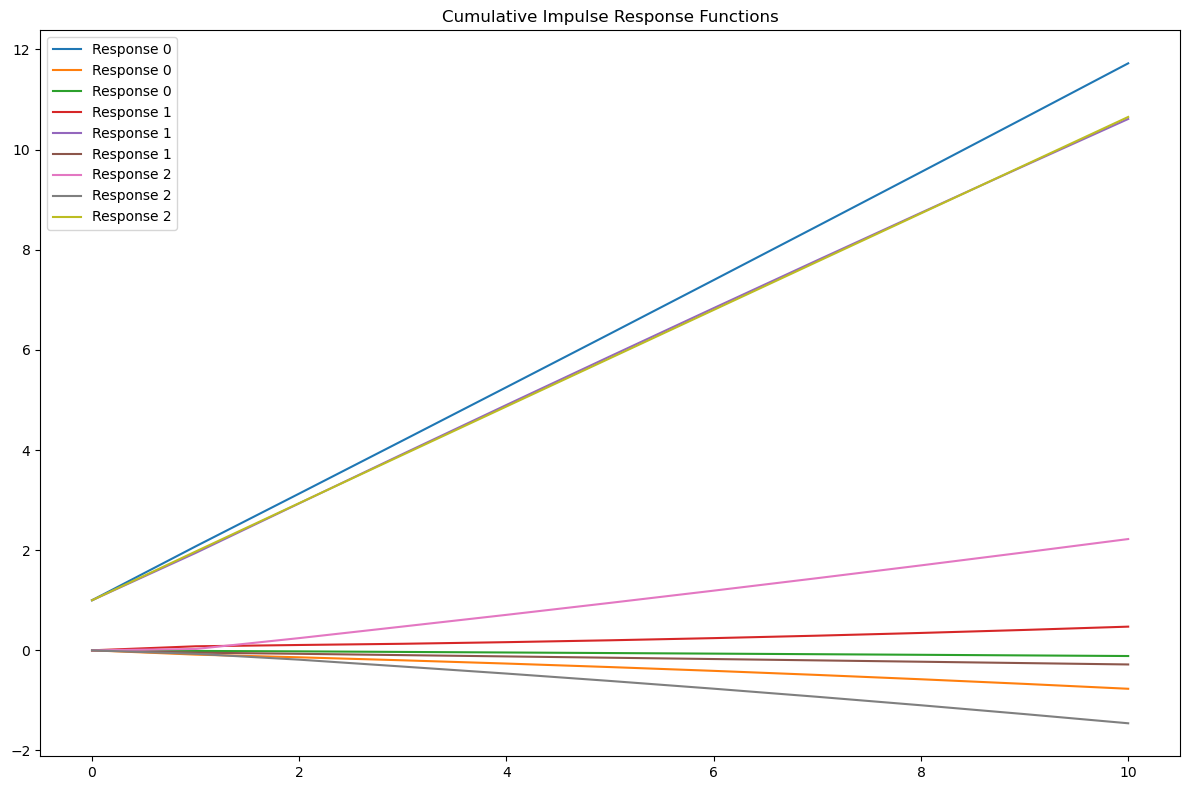

In [ ]:
# Compute cumulative impulse responses manually
irf_cumulative = np.cumsum(irf.irfs, axis=0)

# Plot cumulative impulse responses
plt.figure(figsize=(12, 8))
for i in range(irf_cumulative.shape[1]):
    plt.plot(irf_cumulative[:, i], label=f"Response {i}")
plt.title("Cumulative Impulse Response Functions")
plt.legend()
plt.tight_layout()
plt.show()


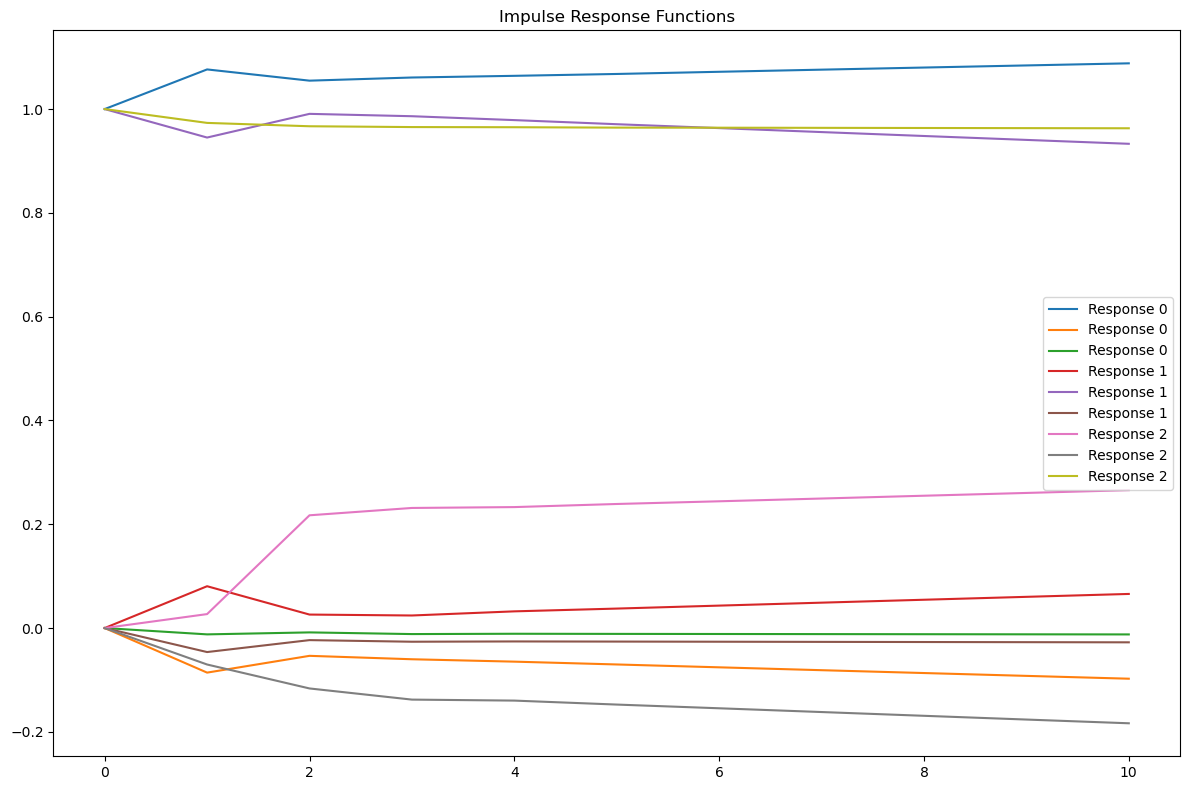

In [ ]:
# Access the impulse response functions by calling the irf method with a number of periods
irf_analysis = vecm.irf(10)  # Number of periods to forecast

# Access the impulse responses from the analysis object
impulse_responses = irf_analysis.irfs  # This contains the impulse response values

# Plot the impulse responses
plt.figure(figsize=(12, 8))
for i in range(impulse_responses.shape[1]):
    plt.plot(impulse_responses[:, i], label=f"Response {i}")
plt.title("Impulse Response Functions")
plt.legend()
plt.tight_layout()
plt.show()


## XOM, DJI, NG=F

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.api import adfuller, kpss
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt

from arch.unitroot import ADF
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen

In [ ]:
# Function to fetch data from Yahoo Finance
def fetch_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    data[tickers] = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    data.index = pd.to_datetime(data.index)
    data = data.dropna()
    return data

In [ ]:
# Function for Augmented Dickey Fuller Test for dataset and its First Difference
def adf_func(data, ticker):

    adf_result = ADF(data[ticker], trend="n", method="bic")
    print(
        f"{ticker} Augmented Dickey-Fuller Unit Root Test\n", adf_result.regression.summary()
    )
    print("\nTest statistics and critical values: \n", adf_result)


    return

In [ ]:
# Selection of Number of Lags for VECM
def select_vecm(data):
    vecm_data = data
    model = VAR(vecm_data)
    lag_selection = model.select_order(maxlags=10, trend="c")
    summary = lag_selection.summary()
    print(summary)
    return lag_selection

In [ ]:
# Johansen Trace Test Result

def jtest(data):
    vecm_data = data
    jtest = coint_johansen(vecm_data, det_order=0, k_ar_diff=10)
    print(f"Eigenvalues of VECM coefficient matrix : {np.round(jtest.eig,3)}\n")
    result = pd.DataFrame(
    {
    "Test statistic": jtest.trace_stat,
    "Critical values (90%)": jtest.trace_stat_crit_vals[:, 0],
    "Critical values (95%)": jtest.trace_stat_crit_vals[:, 1],
    "Critical values (99%)": jtest.trace_stat_crit_vals[:, 2],
    },
    index=["rank=0", "rank<=1", "rank<=2"],
    )
    return result

In [ ]:
data = fetch_data(["XOM", "^DJI", "NG=F"],"2004-12-31","2024-12-31")

[*********************100%***********************]  3 of 3 completed


In [ ]:
print(data.corr())

           XOM      ^DJI      NG=F
XOM   1.000000 -0.312029 -0.394942
^DJI -0.312029  1.000000  0.753380
NG=F -0.394942  0.753380  1.000000


In [ ]:
adf_func(data,"XOM")

XOM Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              6.626
Date:                Fri, 10 Jan 2025   Prob (F-statistic):                     0.00134
Time:                        00:50:16   Log-Likelihood:                          1441.2
No. Observations:                5025   AIC:                                     -2878.
Df Residuals:                    5023   BIC:                                     -2865.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.97

In [ ]:
adf_func(data,"^DJI")

^DJI Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.6500
Date:                Fri, 10 Jan 2025   Prob (F-statistic):                       0.420
Time:                        00:50:16   Log-Likelihood:                         -6697.3
No. Observations:                5026   AIC:                                  1.340e+04
Df Residuals:                    5025   BIC:                                  1.340e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.9

In [ ]:
adf_func(data,"NG=F")

NG=F Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.037
Model:                            OLS   Adj. R-squared (uncentered):              0.035
Method:                 Least Squares   F-statistic:                              19.28
Date:                Fri, 10 Jan 2025   Prob (F-statistic):                    2.73e-35
Time:                        00:50:16   Log-Likelihood:                         -34207.
No. Observations:                5017   AIC:                                  6.843e+04
Df Residuals:                    5007   BIC:                                  6.850e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.9

In [ ]:
select_vecm(data)

C:\Users\elekz\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        25.12       25.12   8.092e+10       25.12
1        6.890      6.905*       981.9       6.895
2        6.880       6.907       972.5       6.889
3        6.875       6.914       967.8       6.889
4        6.877       6.927       969.3       6.894
5        6.875       6.938       967.9       6.897
6        6.875       6.950       968.2       6.901
7        6.865       6.951       958.4       6.895
8        6.853       6.950       946.4       6.887
9        6.850       6.959       943.5       6.888
10      6.842*       6.963      936.7*      6.885*
--------------------------------------------------


In [ ]:
jtest(data)

Eigenvalues of VECM coefficient matrix : [0.003 0.001 0.   ]



,Test statistic,Critical values (90%),Critical values (95%),Critical values (99%)
rank=0,20.136547,27.0669,29.7961,35.4628
rank<=1,4.198569,13.4294,15.4943,19.9349
rank<=2,0.098307,2.7055,3.8415,6.6349


In [ ]:
vecm_co1 = VECM(endog=data, k_ar_diff=10, coint_rank=1, deterministic="ci").fit()
print(vecm_co1.summary())

C:\Users\elekz\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Det. terms outside the coint. relation & lagged endog. parameters for equation XOM
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.XOM        -0.0456      0.014     -3.205      0.001      -0.074      -0.018
L1.^DJI        0.0037      0.003      1.102      0.270      -0.003       0.010
L1.NG=F      1.82e-05   1.38e-05      1.320      0.187   -8.82e-06    4.52e-05
L2.XOM         0.0141      0.014      0.991      0.322      -0.014       0.042
L2.^DJI       -0.0078      0.003     -2.332      0.020      -0.014      -0.001
L2.NG=F     2.023e-05   1.38e-05      1.469      0.142   -6.75e-06    4.72e-05
L3.XOM        -0.0087      0.014     -0.612      0.540      -0.037       0.019
L3.^DJI        0.0036      0.003      1.071      0.284      -0.003       0.010
L3.NG=F    -1.772e-05   1.38e-05     -1.287      0.198   -4.47e-05    9.26e-06
L4.XOM         0.0050      0.014      0.354     

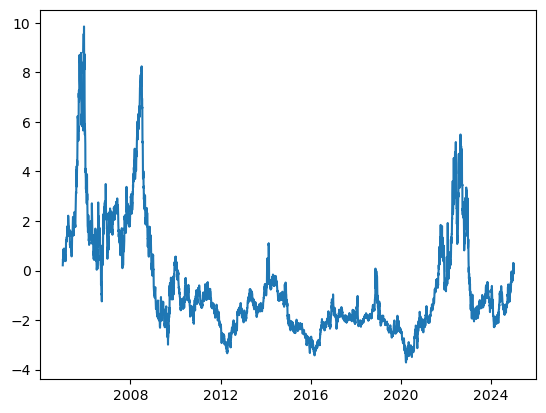

In [ ]:
S1 = (
vecm_co1.const_coint[0][0]
+ vecm_co1.beta[0][0] * data["XOM"]
+ vecm_co1.beta[1][0] * data["^DJI"]
+ vecm_co1.beta[2][0] * data["NG=F"]
)
plt.plot(S1)
plt.show()

In [ ]:
vecm_co2 = VECM(endog=data, k_ar_diff=10, coint_rank=2, deterministic="ci").fit()
print(vecm_co2.summary())

C:\Users\elekz\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Det. terms outside the coint. relation & lagged endog. parameters for equation XOM
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.XOM        -0.0456      0.014     -3.206      0.001      -0.074      -0.018
L1.^DJI        0.0037      0.003      1.103      0.270      -0.003       0.010
L1.NG=F     1.819e-05   1.38e-05      1.319      0.187   -8.85e-06    4.52e-05
L2.XOM         0.0141      0.014      0.990      0.322      -0.014       0.042
L2.^DJI       -0.0078      0.003     -2.331      0.020      -0.014      -0.001
L2.NG=F     2.021e-05   1.38e-05      1.467      0.142   -6.78e-06    4.72e-05
L3.XOM        -0.0087      0.014     -0.613      0.540      -0.037       0.019
L3.^DJI        0.0036      0.003      1.071      0.284      -0.003       0.010
L3.NG=F    -1.773e-05   1.38e-05     -1.288      0.198   -4.47e-05    9.25e-06
L4.XOM         0.0050      0.014      0.353     

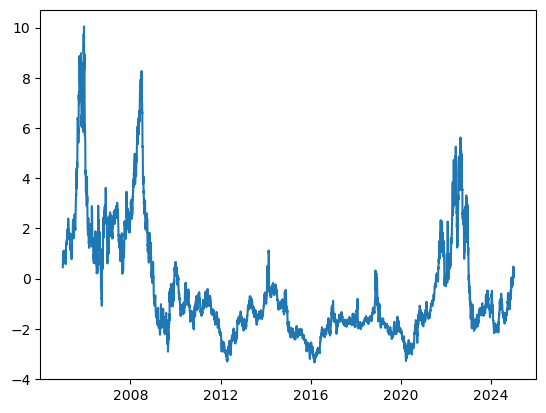

In [ ]:
S2 = (
vecm_co2.const_coint[0][0]
+ vecm_co2.beta[0][0] * data["XOM"]
+ vecm_co2.beta[1][0] * data["^DJI"]
+ vecm_co2.beta[2][0] * data["NG=F"]
)
plt.plot(S2)
plt.show()

In [ ]:
S1_adf = ADF(S1, trend="n", method="bic")
print("Augmented Dickey-Fuller Unit Root Test\n", S1_adf.regression.summary())
print("\nTest statistics and critical values: \n", S1_adf)

Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              8.129
Date:                Fri, 10 Jan 2025   Prob (F-statistic):                     0.00437
Time:                        00:50:18   Log-Likelihood:                          1382.8
No. Observations:                5026   AIC:                                     -2764.
Df Residuals:                    5025   BIC:                                     -2757.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-

In [ ]:
S2_adf = ADF(S2, trend="n", method="bic")
print("Augmented Dickey-Fuller Unit Root Test\n", S2_adf.regression.summary())
print("\nTest statistics and critical values: \n", S2_adf)

Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              9.141
Date:                Fri, 10 Jan 2025   Prob (F-statistic):                    0.000109
Time:                        00:50:18   Log-Likelihood:                          1417.4
No. Observations:                5025   AIC:                                     -2831.
Df Residuals:                    5023   BIC:                                     -2818.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-

## EUR, USD, JPY

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.gofplots import qqplot  # Import qqplot here
from scipy.stats import shapiro


# Function to fetch data from Yahoo Finance
def fetch_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    data = data.dropna()  # Drop NaN values
    return data

In [ ]:
# Perform ADF test
def adf_test(series, name):
    result = adfuller(series, autolag='AIC')
    print(f"ADF Test for {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"P-value: {result[1]}")
    for key, value in result[4].items():
        print(f"Critical Values ({key}): {value}")
    print("Series is non-stationary" if result[1] > 0.05 else "Series is stationary")
    print()


def kpss_test(series, name, regression_type="c", lags='auto'):
    try:
        result = kpss(series, regression=regression_type, nlags=lags)
        print(f"KPSS Test for {name}:")
        print(f"KPSS Statistic: {result[0]}")
        print(f"P-value: {result[1]}")
        for key, value in result[3].items():
            print(f"Critical Values ({key}): {value}")
        print("Series is stationary" if result[1] > 0.05 else "Series is non-stationary")
    except ValueError as e:
        print(f"Error in KPSS Test for {name}: {e}")
    print()


In [ ]:
# Function to select the optimal lag based on AIC or BIC
def select_optimal_lag(data, max_lags=15, criterion='aic'):
    model = VAR(data)
    results = model.select_order(maxlags=max_lags)

    if criterion == 'aic':
        optimal_lag = results.selected_orders['aic']
    elif criterion == 'bic':
        optimal_lag = results.selected_orders['bic']
    else:
        raise ValueError("Criterion must be either 'aic' or 'bic'")

    print(f"Optimal Lag selected based on {criterion.upper()}: {optimal_lag}")
    return optimal_lag


In [ ]:
# Enhanced Johansen Test with automatic lag selection
def johansen_test(data, det_order=0, max_lags=15, criterion='aic'):
    # Automatically select the optimal lag
    optimal_lag = select_optimal_lag(data, max_lags, criterion)

    print(f"Running Johansen Cointegration Test with det_order={det_order} and optimal lag={optimal_lag}:")
    result = coint_johansen(data, det_order, optimal_lag)

    # Eigenvalues (Strength of cointegration)
    print("Eigenvalues:", result.eig)

    # Trace Statistics (Testing the null hypothesis of at most r cointegrating vectors)
    print("Trace Statistics:", result.lr1)
    print("Critical Values (Trace) at 1%, 5%, 10%:", result.cvt)

    # Max Eigen Statistics (Testing the null hypothesis of exactly r cointegrating vectors)
    print("Max Eigen Statistics:", result.lr2)
    print("Critical Values (Max Eigen) at 1%, 5%, 10%:", result.cvm)

    # Interpret Results for Trace Test
    print("\nInterpretation (Trace Test):")
    for i, lr1 in enumerate(result.lr1):
        print(f"r={i} (at most {i} cointegrating vectors): Test Statistic = {lr1}, Critical Value = {result.cvt[i, 1]}")
        if lr1 > result.cvt[i, 1]:
            print(f"  - Reject the null hypothesis: There are more than {i} cointegrating vectors.")
        else:
            print(f"  - Fail to reject the null hypothesis: At most {i} cointegrating vectors.")

    # Interpret Results for Max Eigen Test
    print("\nInterpretation (Max Eigen Test):")
    for i, lr2 in enumerate(result.lr2):
        print(f"r={i} (exactly {i} cointegrating vectors): Test Statistic = {lr2}, Critical Value = {result.cvm[i, 1]}")
        if lr2 > result.cvm[i, 1]:
            print(f"  - Reject the null hypothesis: There is exactly {i} cointegrating vector.")
        else:
            print(f"  - Fail to reject the null hypothesis: There is more than {i} cointegrating vectors.")

    print()


In [ ]:
# Fetch and process data
start_date = "2001-01-01"
end_date = "2023-12-31"
tickers = ["EURUSD=X", "GBPUSD=X", "JPY=X"]  # EUR/USD, GBP/USD, JPY/USD
data = fetch_data(tickers, start_date, end_date)



[*********************100%***********************]  3 of 3 completed


In [ ]:
# Apply log transformation
data_log = np.log(data).dropna()

# Add frequency information to the date index
data_log = data_log.asfreq('D')


In [ ]:
# Check for NaN or inf values
print("Number of NaN or inf values in log-transformed data:")
print(data_log.isna().sum())
print(np.isinf(data_log).sum())

# Drop rows with NaN or inf values
data_log = data_log.replace([np.inf, -np.inf], np.nan).dropna()


# Differencing to make the series stationary
data_log_diff = data_log.diff().dropna()

Number of NaN or inf values in log-transformed data:
Ticker
EURUSD=X    2128
GBPUSD=X    2128
JPY=X       2128
dtype: int64
Ticker
EURUSD=X    0
GBPUSD=X    0
JPY=X       0
dtype: int64


In [ ]:
# Perform stationarity tests on log-transformed levels
print("Stationarity Tests on Log-Transformed Levels:")
adf_test(data_log["EURUSD=X"], "EUR/USD (Log Levels)")
adf_test(data_log["GBPUSD=X"], "GBP/USD (Log Levels)")
adf_test(data_log["JPY=X"], "JPY/USD (Log Levels)")

kpss_test(data_log["EURUSD=X"], "EUR/USD (Log Levels)")
kpss_test(data_log["GBPUSD=X"], "GBP/USD (Log Levels)")
kpss_test(data_log["JPY=X"], "JPY/USD (Log Levels)")


Stationarity Tests on Log-Transformed Levels:
ADF Test for EUR/USD (Log Levels):
ADF Statistic: -1.8672686085968238
P-value: 0.34761212328018315
Critical Values (1%): -3.4316145046899154
Critical Values (5%): -2.862098778472762
Critical Values (10%): -2.5670674377477467
Series is non-stationary

ADF Test for GBP/USD (Log Levels):
ADF Statistic: -1.3549602528825977
P-value: 0.6036683170876895
Critical Values (1%): -3.4316072114774774
Critical Values (5%): -2.862095556318873
Critical Values (10%): -2.5670657224783042
Series is non-stationary

ADF Test for JPY/USD (Log Levels):
ADF Statistic: -0.7797482919886677
P-value: 0.8249985967388112
Critical Values (1%): -3.4316145046899154
Critical Values (5%): -2.862098778472762
Critical Values (10%): -2.5670674377477467
Series is non-stationary

KPSS Test for EUR/USD (Log Levels):
KPSS Statistic: 6.5933685427666
P-value: 0.01
Critical Values (10%): 0.347
Critical Values (5%): 0.463
Critical Values (2.5%): 0.574
Critical Values (1%): 0.739
Series

C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4249348360.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)
C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4249348360.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)
C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4249348360.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)


In [ ]:
# Perform stationarity tests on first differences
print("Stationarity Tests on First Differences:")
adf_test(data_log_diff["EURUSD=X"], "EUR/USD (First Differences)")
adf_test(data_log_diff["GBPUSD=X"], "GBP/USD (First Differences)")
adf_test(data_log_diff["JPY=X"], "JPY/USD (First Differences)")

kpss_test(data_log_diff["EURUSD=X"], "EUR/USD (First Differences)")
kpss_test(data_log_diff["GBPUSD=X"], "GBP/USD (First Differences)")
kpss_test(data_log_diff["JPY=X"], "JPY/USD (First Differences)")


Stationarity Tests on First Differences:
ADF Test for EUR/USD (First Differences):
ADF Statistic: -13.248029688031897
P-value: 8.892041813324885e-25
Critical Values (1%): -3.4316145046899154
Critical Values (5%): -2.862098778472762
Critical Values (10%): -2.5670674377477467
Series is stationary

ADF Test for GBP/USD (First Differences):
ADF Statistic: -70.12063425971017
P-value: 0.0
Critical Values (1%): -3.4316072114774774
Critical Values (5%): -2.862095556318873
Critical Values (10%): -2.5670657224783042
Series is stationary

ADF Test for JPY/USD (First Differences):
ADF Statistic: -12.968646698146818
P-value: 3.1147116467969754e-24
Critical Values (1%): -3.4316145046899154
Critical Values (5%): -2.862098778472762
Critical Values (10%): -2.5670674377477467
Series is stationary

KPSS Test for EUR/USD (First Differences):
KPSS Statistic: 0.07101366951063828
P-value: 0.1
Critical Values (10%): 0.347
Critical Values (5%): 0.463
Critical Values (2.5%): 0.574
Critical Values (1%): 0.739
Se

C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4249348360.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)
C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4249348360.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)
C:\Users\elekz\AppData\Local\Temp\ipykernel_10800\4249348360.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression_type, nlags=lags)


In [ ]:
# Run Johansen cointegration test on log-transformed levels
print("Johansen Cointegration Test on Log-Transformed Levels:")
johansen_test(data_log, det_order=0, max_lags=15, criterion='aic')


Johansen Cointegration Test on Log-Transformed Levels:


C:\Users\elekz\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal Lag selected based on AIC: 8
Running Johansen Cointegration Test with det_order=0 and optimal lag=8:
Eigenvalues: [1.92601554e-03 5.74130172e-04 8.71287044e-05]
Trace Statistics: [13.45659333  3.43743897  0.4528276 ]
Critical Values (Trace) at 1%, 5%, 10%: [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max Eigen Statistics: [10.01915436  2.98461136  0.4528276 ]
Critical Values (Max Eigen) at 1%, 5%, 10%: [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]

Interpretation (Trace Test):
r=0 (at most 0 cointegrating vectors): Test Statistic = 13.456593327510003, Critical Value = 29.7961
  - Fail to reject the null hypothesis: At most 0 cointegrating vectors.
r=1 (at most 1 cointegrating vectors): Test Statistic = 3.4374389683784528, Critical Value = 15.4943
  - Fail to reject the null hypothesis: At most 1 cointegrating vectors.
r=2 (at most 2 cointegrating vectors): Test Statistic = 0.45282760433517866, Critical Val

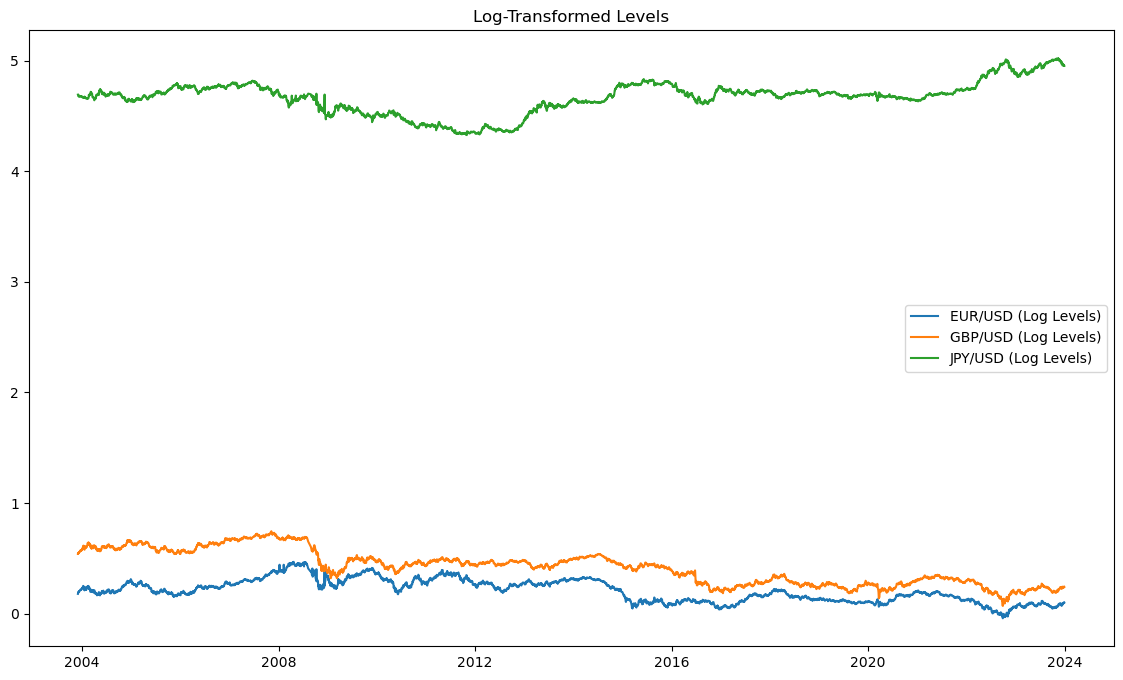

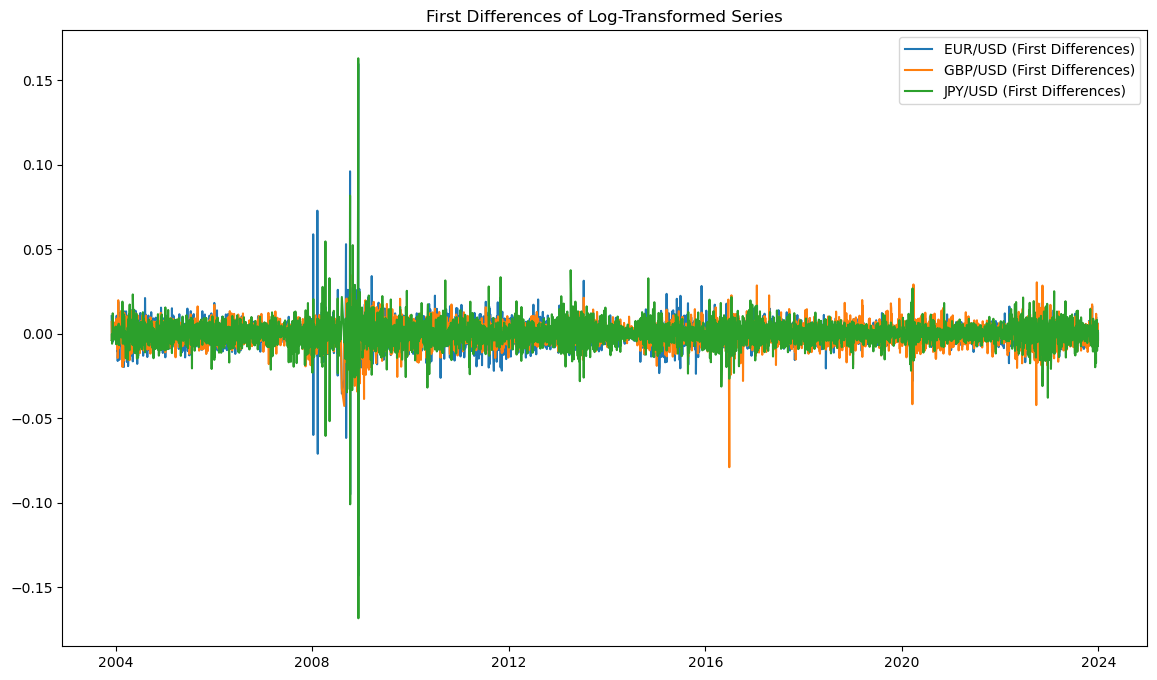

In [ ]:
# Plot log-transformed levels
plt.figure(figsize=(14, 8))
plt.plot(data_log["EURUSD=X"], label="EUR/USD (Log Levels)")
plt.plot(data_log["GBPUSD=X"], label="GBP/USD (Log Levels)")
plt.plot(data_log["JPY=X"], label="JPY/USD (Log Levels)")
plt.title("Log-Transformed Levels")
plt.legend()
plt.show()

# Plot first differences
plt.figure(figsize=(14, 8))
plt.plot(data_log_diff["EURUSD=X"], label="EUR/USD (First Differences)")
plt.plot(data_log_diff["GBPUSD=X"], label="GBP/USD (First Differences)")
plt.plot(data_log_diff["JPY=X"], label="JPY/USD (First Differences)")
plt.title("First Differences of Log-Transformed Series")
plt.legend()
plt.show()